In [70]:
import pandas as pd
import json
import networkx as nx
from itertools import combinations
import netwulf
import random
import numpy as np
import seaborn as sns
from scipy.stats import norm

# Config
SEED = 42
sns.set_theme()

## Dataset

In [32]:
# Load it back
names_df = pd.read_parquet("dataset-test/filtered_names_df_big.parquet")

# Deserialize JSON strings back to Python objects
names_df["coref_clusters"] = names_df["coref_clusters"].apply(json.loads)
names_df["person_descriptions"] = names_df["person_descriptions"].apply(json.loads)

In [33]:
names_df

,canonical_name,aliases,article_ids,person_descriptions,coref_clusters,num_articles,gender
0,Dronning Margrethe,"[Dronning, Dronning Magrethe, Dronning Margret...","[3038521, 3056484, 3077475, 3079947, 3084765, ...","{'3193653': ['farmor', 'dronning'], '3196007':...",{'3056484': {'coref_clusters_5': ['Dronning Ma...,408,female
1,Joachim,"[Joachim, Joacim]","[3061656, 3082698, 3083145, 3083699, 3084765, ...","{'3061656': ['prins', 'prinsesse', ' '], '3082...","{'3061656': {'coref_clusters_1': ['Hun', 'Hun'...",379,male
2,Henrik,"[Henri, Henrik]","[3038205, 3038521, 3056484, 3079947, 3087749, ...","{'3038205': ['indflytter', 'år', 'mand'], '303...",{'3038205': {'coref_clusters_5': ['Henrik på 3...,330,male
3,Kronprins Frederik,"[Frede, Frederik, Frederik Og, Kronprins, Kron...","[3041066, 3079947, 3083793, 3085326, 3187038, ...","{'3191251': ['ynder', 'kæreste', 'ynder', 'kær...",{'3085326': {'coref_clusters_9': ['kronprins F...,271,male
4,Casper Christensen,"[Cajsa Christensen, Caper Christensen, Casper,...","[3103407, 3198301, 3227493, 4003217, 4006373, ...","{'3103407': ['trio', 'tæskehold'], '3198301': ...",{'3198301': {'coref_clusters_1': ['komikeren F...,258,male
...,...,...,...,...,...,...,...
4157,Zlatan,[Zlatan],"[4818626, 5302870, 6333307, 6704212, 9727831]",{'6704212': ['histori']},{},5,male
4158,Diva-Irina,"[Diva-Irina, Irina]","[4503627, 4706555, 4729665, 4730109, 4730112]","{'4706555': [' '], '4730109': [' '], '4730112'...","{'4503627': {'coref_clusters_1': ['Du', 'hende...",5,female
4159,Zara Larsson,"[Larsson, Zara Larsson]","[6486148, 8099774, 8504170, 8517871, 9562692]","{'6486148': ['dame', 'popstjern', ' ', 'løber'...",{'6486148': {'coref_clusters_1': ['popstjernen...,5,female
4160,Zaid,[Zaid],"[6252475, 6493406, 6494837, 9716223, 9717129]","{'6252475': ['hævne', 'hjertekirurg', 'hovedro...","{'6252475': {'coref_clusters_1': ['Dar Salim',...",5,male


## Network Analysis

### Create and filter co-mention network

Create the co-mention network:

In [34]:
# Create graph
G = nx.Graph()

# Add nodes and node attributes from dataframe
for _, row in names_df.iterrows():
    G.add_node(
        row["canonical_name"],
        aliases=row["aliases"],
        article_ids=row["article_ids"],
        person_descriptions=row["person_descriptions"],
        coref_clusters=row["coref_clusters"],
        gender=row["gender"]
    )

# Add edges between between persons if co-mentioned
for (name1, data1), (name2, data2) in combinations(G.nodes(data=True), 2):
    shared_articles = set(data1['article_ids']) & set(data2['article_ids'])
    if shared_articles:
        G.add_edge(name1, name2, weight=len(shared_articles))
        G.add_edge(name2, name1, weight=len(shared_articles))  # Make edges bidirectional for DiGraph

Remove weak links (edges with weight ≤2):

In [35]:
weight_threshold = 2

# Remove edges with weight <= threshold
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] <= weight_threshold]
G.remove_edges_from(edges_to_remove)

Remove resulting isolates (nodes with no edges):

In [36]:
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

### Community detection

Use Louvain algorithm for community detection. Add partition as node attribtue `group`. This makes it so that `netwulf` can automatically color code nodes based on the community selected for the node by Louvain.

In [37]:
from community import community_louvain

partition = community_louvain.best_partition(G, random_state=SEED)

# Add 'group' attribute based on community
nx.set_node_attributes(G, partition, "group")

In [21]:
config = {
    # Input/output
    'zoom': 1,
    # Physics
    'node_charge': -5,
    'node_gravity': 0.1,
    'link_distance': 15,
    'link_distance_variation': 0,
    'node_collision': True,
    'wiggle_nodes': False,
    'freeze_nodes': False,
    # Nodes
    'node_fill_color': '#79aaa0',
    'node_stroke_color': '#555555',
    'node_label_color': '#000000',
    'display_node_labels': False,
    'scale_node_size_by_strength': True,
    'node_size': 5,
    'node_stroke_width': 0,
    'node_size_variation': 0.25,
    # Links
    'link_color': '#7c7c7c',
    'link_width': 2,
    'link_alpha': 0.5,
    'link_width_variation': 0.5,
    # Thresholding
    'display_singleton_nodes': False,
    'min_link_weight_percentile': 0.02,
    'max_link_weight_percentile': 1
}

netwulf.visualize(G, port=random.randint(1, 100), config=config)

(None, None)

### Power law

Check if the graph follows the power-law distribution:

Alpha (power-law exponent): 3.2071

Log-likelihood ratio (vs exponential): R = 22.3912, p = 0.0022
✅ Power-law is a significantly better fit than exponential.


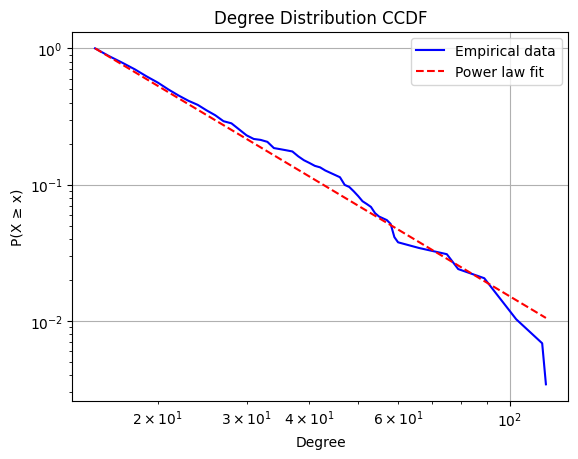

In [38]:
import powerlaw
import matplotlib.pyplot as plt  # Correct import statement
# Step 1: Get degrees (exclude zero degrees just in case)
degrees = [deg for _, deg in G.degree() if deg > 0]

# Step 2: Fit power-law model
fit = powerlaw.Fit(degrees, verbose=False)

# Step 3: Print alpha (power-law exponent) and x_min
print(f"Alpha (power-law exponent): {fit.power_law.alpha:.4f}")

# Step 4: Compare with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"\nLog-likelihood ratio (vs exponential): R = {R:.4f}, p = {p:.4f}")
if R > 0 and p < 0.05:
    print("✅ Power-law is a significantly better fit than exponential.")
else:
    print("❌ Power-law is NOT a significantly better fit than exponential.")

# Step 5: Plot
fig = fit.plot_ccdf(color='blue', label='Empirical data')
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power law fit')
plt.legend()
plt.title("Degree Distribution CCDF")
plt.xlabel("Degree")
plt.ylabel("P(X ≥ x)")
plt.grid(True)
plt.show()


Since $\alpha \approx 3.2$, the degree distribution decays fairly steeply. The network is scale-free, but the tail is moderate. This implies that hubs exist, but no single celebrity dominates the network. This also suggests a hierarchical structure where a small number of celebrities have many connections, yet centrality is shared across several figures.

What this means is that Ekstrabladet doesn't center entirely around one individual. Instead, multiple overlapping "celebrity communities" exist. Mainly, in our case, royal families, reality stars, politicians etc.


### Node connections

Check a random node (between 1 and 100) and its connections:

In [43]:
# Ensure graph is not empty
if len(G.nodes) == 0:
    print("Graph is empty after filtering.")
else:
    # Pick a random node
    random_node = list(G.nodes)[random.randint(1, 100)]
    print(f"Random node: {random_node}\n")

    # Get neighbors and shared article counts
    for neighbor in G.neighbors(random_node):
        weight = G[random_node][neighbor]["weight"]
        print(f"Shares {weight} article(s) with: {neighbor}")


Random node: Stephanie

Shares 3 article(s) with: Frederik
Shares 6 article(s) with: Christian
Shares 3 article(s) with: Gud
Shares 22 article(s) with: Linse Kessler
Shares 3 article(s) with: Peter
Shares 4 article(s) with: Isabella
Shares 40 article(s) with: Geggo
Shares 19 article(s) with: Linse
Shares 7 article(s) with: Mikkel
Shares 3 article(s) with: Charles
Shares 5 article(s) with: Frederik Fetterlein
Shares 6 article(s) with: Emma
Shares 4 article(s) with: Gustav
Shares 7 article(s) with: Caroline
Shares 7 article(s) with: Mikkel Kessler
Shares 3 article(s) with: David
Shares 4 article(s) with: Simon
Shares 3 article(s) with: Christina
Shares 13 article(s) with: Cengiz
Shares 3 article(s) with: Albert
Shares 10 article(s) with: Alba
Shares 7 article(s) with: Rachel
Shares 6 article(s) with: Mai Manniche
Shares 4 article(s) with: Madeleine
Shares 4 article(s) with: Lene
Shares 4 article(s) with: Mopper
Shares 3 article(s) with: Romeo
Shares 5 article(s) with: Ann
Shares 3 articl

### Summary Statistics

In [56]:
# Create a list of dictionaries where each dictionary represents a node
node_data = []
for node, data in G.nodes(data=True):
    node_info = data.copy()  # Copy node attributes
    node_info["node"] = node  # Add the node name itself
    node_info["degree"] = G.degree[node]  # Add degree as an attribute
    node_data.append(node_info)

# Convert the list of dictionaries to a pandas DataFrame
df_graph = pd.DataFrame(node_data)

# Show the first few rows to check the structure
df_graph.head()

,aliases,article_ids,person_descriptions,coref_clusters,gender,group,node,degree
0,"[Dronning, Dronning Magrethe, Dronning Margret...","[3038521, 3056484, 3077475, 3079947, 3084765, ...","{'3193653': ['farmor', 'dronning'], '3196007':...",{'3056484': {'coref_clusters_5': ['Dronning Ma...,female,0,Dronning Margrethe,118
1,"[Joachim, Joacim]","[3061656, 3082698, 3083145, 3083699, 3084765, ...","{'3061656': ['prins', 'prinsesse', ' '], '3082...","{'3061656': {'coref_clusters_1': ['Hun', 'Hun'...",male,0,Joachim,116
2,"[Henri, Henrik]","[3038205, 3038521, 3056484, 3079947, 3087749, ...","{'3038205': ['indflytter', 'år', 'mand'], '303...",{'3038205': {'coref_clusters_5': ['Henrik på 3...,male,0,Henrik,103
3,"[Frede, Frederik, Frederik Og, Kronprins, Kron...","[3041066, 3079947, 3083793, 3085326, 3187038, ...","{'3191251': ['ynder', 'kæreste', 'ynder', 'kær...",{'3085326': {'coref_clusters_9': ['kronprins F...,male,0,Kronprins Frederik,66
4,"[Cajsa Christensen, Caper Christensen, Casper,...","[3103407, 3198301, 3227493, 4003217, 4006373, ...","{'3103407': ['trio', 'tæskehold'], '3198301': ...",{'3198301': {'coref_clusters_1': ['komikeren F...,male,1,Casper Christensen,75


#### Overall

In [51]:
df_graph["degree"].describe()

count    3086.000000
mean        5.995463
std         8.830659
min         1.000000
25%         2.000000
50%         3.000000
75%         7.000000
max       118.000000
Name: degree, dtype: float64

#### Per gender

In [ ]:
# Summary statistics for degree by gender
degree_stats = df_graph.groupby('gender')['degree'].describe()

clustering_stats = df_graph.groupby('gender').apply(lambda group: group['node'].apply(lambda node: nx.clustering(G, node)).mean())

degree_stats

/tmp/ipykernel_36828/1510428866.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clustering_stats = df_graph.groupby('gender').apply(lambda group: group['node'].apply(lambda node: nx.clustering(G, node)).mean())


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,1325.0,6.252830,8.943862,1.0,2.0,3.0,7.0,118.0
male,1719.0,5.830716,8.826544,1.0,2.0,3.0,6.0,116.0
unknown,42.0,4.619048,3.825157,1.0,2.0,3.0,6.0,13.0


In [55]:
clustering_stats

gender
female     0.422529
male       0.417211
unknown    0.669527
dtype: float64

#### Top celebrities by degree

By gender:

In [67]:
df_graph[df_graph["gender"] == "male"].nlargest(n=5, columns="degree")[["node", "degree"]]

,node,degree
1,Joachim,116
2,Henrik,103
6,Frederik,89
7,Christian,89
18,Silas Holst,89


In [68]:
df_graph[df_graph["gender"] == "female"].nlargest(n=5, columns="degree")[["node", "degree"]]

,node,degree
0,Dronning Margrethe,118
5,Mary,79
8,Alexandra,75
10,Marie,59
17,Mascha Vang,58


What we see here is that:
- Males have numerical dominance, however the max degree is higher for women due to Magrethe as an outlier.
- Both genders share the same median degree. This indicates that male and female are mentioned together equally in articles.
- The danish royal house are frequently mentioned. They dominate both the male and female gender.

### Network Characteristics

#### Assortativity coefficient

In [69]:
nx.degree_assortativity_coefficient(G)

0.08219694403167355

This shows slightly positive degree assortativity: high-degree nodes tend to connect (slightly) more with other high-degree nodes. This is also supported by the richer gets richer effect shown, i.e. the media write about celebrities and celebrities may gain traffic from the exposure.

#### Random Network

In [71]:
# Your real network
r_real = nx.degree_assortativity_coefficient(G)

# Parameters
n_randomizations = 200
nswap = 10 * G.number_of_edges()
max_tries = nswap * 100
seed = 4

# Store assortativity va lues from randomized graphs
r_random = []

for i in range(n_randomizations):
    H_copy = G.copy()
    # Perform edge swaps while preserving degree sequence
    nx.double_edge_swap(H_copy, nswap=nswap, max_tries=max_tries, seed=seed + i)
    r = nx.degree_assortativity_coefficient(H_copy)
    r_random.append(r)

# Compute mean and std of the null distribution
mean_r = np.mean(r_random)
std_r = np.std(r_random)

# Z-score and (two-tailed) p-value
z = (r_real - mean_r) / std_r
p_value = 2 * (1 - norm.cdf(abs(z)))  # Two-tailed test

# Results
print(f"Real assortativity: {r_real:.4f}")
print(f"Random mean: {mean_r:.4f}, std: {std_r:.4f}")
print(f"Z-score: {z:.2f}")
print(f"P-value: {p_value:.2e}")

Real assortativity: 0.0822
Random mean: -0.0264, std: 0.0085
Z-score: 12.72
P-value: 0.00e+00


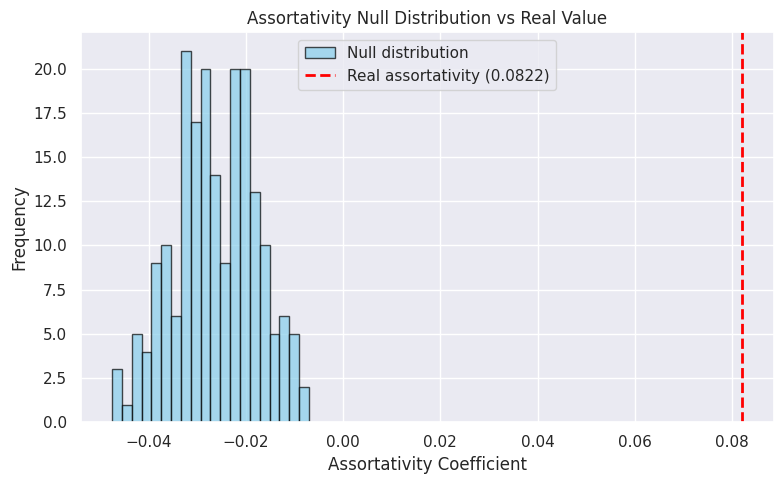

In [72]:
# Plot
plt.figure(figsize=(8, 5))
plt.hist(r_random, bins=20, alpha=0.7, color='skyblue', edgecolor='black', label='Null distribution')
plt.axvline(r_real, color='red', linestyle='--', linewidth=2, label=f'Real assortativity ({r_real:.4f})')

plt.title('Assortativity Null Distribution vs Real Value')
plt.xlabel('Assortativity Coefficient')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This indicates that the assortativity coefficient from the randomized networks generated from the real graph stats are indeed far away from the real graph. In other words, the real graph structure wrt. the assortativity coefficient is not randomized and carries a proper non-randomized order.

This is also supported by the insanely low p-value.

#### Shortest Paths

Construct a subgraph containing all the nodes of the largest component in the graph:

In [109]:
# Get connected components
connected_components = nx.algorithms.connected_components(G)

# Find giant component
giant_component = max(connected_components, key=len)

# Construct subgraph
G_sub = nx.Graph.subgraph(G, giant_component)

Get induced subgraphs from connected components:

In [120]:
# Induced subgraphs
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

# Get number of nodes for each subgraph
S_nodes = [len(GS.nodes) for GS in S]

Let's have a look at the giant component and it's contribution to the overall graph/network, also vs. other components:

In [121]:
len(giant_component) / sum(S_nodes)

0.9144523655217109

Calculate average shortest path between two nodes in the giant component:

In [74]:
avg_shortest_path = nx.average_shortest_path_length(G_sub)

In [75]:
avg_shortest_path

4.638309268518912